# FORCE training
Taken from the [`brainpy` docs](https://brainpy-examples.readthedocs.io/en/latest/recurrent_networks/Sussillo_Abbott_2009_FORCE_Learning.html)

In [1]:
import brainpy as bp
import brainpy.math as bm
bm.set_platform("cpu")

import numpy as np
import matplotlib.pyplot as plt

In [3]:
class EchoStateNet(bp.DynamicalSystem):
    r"""The continuous-time Echo State Network.

        math::

        \frac{dh}{dt} = -h + W_{ir} * x + W_{rr} * r + W_{or} * z \\
        r = \tanh(h) \\
        o = W_{ro} * r
    """

    def __init__(self, num_input, num_hidden, num_output,
                 tau=1.0, dt=0.1, g=1.8, alpha=1.0, **kwargs):
        
        super(EchoStateNet, self).__init__(**kwargs)

        # parameters
        self.num_input = num_input
        self.num_hidden = num_hidden
        self.num_output = num_output
        self.tau = tau
        self.dt = dt
        self.g = g
        self.alpha = alpha

        # weights
        self.w_ir = bm.random.normal(size=(num_input, num_hidden)) / bm.sqrt(num_input)
        self.w_rr = g * bm.random.normal(size=(num_hidden, num_hidden)) / bm.sqrt(num_hidden)
        self.w_or = bm.random.normal(size=(num_output, num_hidden))
        w_ro = bm.random.normal(size=(num_hidden, num_output)) / bm.sqrt(num_hidden)
        self.w_ro = bm.Variable(w_ro)

        # variables
        self.h = bm.Variable(bm.random.normal(size=num_hidden) * 0.5)  # hidden
        self.r = bm.Variable(bm.tanh(self.h))  # firing rate
        self.o = bm.Variable(bm.dot(self.r, w_ro))  # output unit
        self.P = bm.Variable(bm.eye(num_hidden) * self.alpha)  # inverse correlation matrix

    def update(self, x):
        # update the hidden and output state
        dhdt = -self.h + bm.dot(x, self.w_ir)
        dhdt += bm.dot(self.r, self.w_rr)
        dhdt += bm.dot(self.o, self.w_or)
        self.h += self.dt / self.tau * dhdt
        self.r.value = bm.tanh(self.h)
        self.o.value = bm.dot(self.r, self.w_ro)

    def rls(self, target):
        # update the inverse correlation matrix
        k = bm.expand_dims(bm.dot(self.P, self.r), axis=1)  # (num_hidden, 1)
        hPh = bm.dot(self.r.T, k)  # (1,)
        c = 1.0 / (1.0 + hPh)  # (1,)
        self.P -= bm.dot(k * c, k.T)  # (num_hidden, num_hidden)
        # update the output weights
        e = bm.atleast_2d(self.o - target)  # (1, num_output)
        dw = bm.dot(-c * k, e)  # (num_hidden, num_output)
        self.w_ro += dw

    def simulate(self, xs):
        f = bm.make_loop(self.update, dyn_vars=[self.h, self.r, self.o], out_vars=[self.r, self.o])
        return f(xs)

    def train(self, xs, targets):
        def _f(x):
            input, target = x
            self.update(input)
            self.rls(target)

        f = bm.make_loop(_f, dyn_vars=self.vars(), out_vars=[self.r, self.o])
        return f([xs, targets])

In [4]:
def print_force(ts, rates, outs, targets, duration, num_to_plot=10):
    """Plot activations and outputs for the Echo state network."""
    fig = plt.figure(figsize=(16, 16))

    ax_to = fig.add_subplot(321)
    ax_to.plot(ts, targets + 2 * np.arange(0, targets.shape[1]), "g")
    ax_to.plot(ts, outs + 2 * np.arange(0, outs.shape[1]), "r")
    ax_to.set_xlim((0, duration))
    ax_to.set_title("Target (green), Output (red)")
    ax_to.set_xlabel("Time")
    ax_to.set_ylabel("Dimension")

    ax_ha = fig.add_subplot(122)
    ax_ha.imshow(rates.T, interpolation=None)
    ax_ha.set_title("Hidden activations of ESN")
    ax_ha.set_xlabel("Time")
    ax_ha.set_ylabel("Dimension")

    ax_ha_sep = fig.add_subplot(323)
    ax_ha_sep.plot(ts, rates[:, :num_to_plot] + 2 * np.arange(0, num_to_plot), "b")
    ax_ha_sep.set_xlim((0, duration))
    ax_ha_sep.set_title(f"{num_to_plot} hidden activations of ESN")
    ax_ha_sep.set_xlabel("Time")
    ax_ha_sep.set_ylabel("Dimension")

    ax_err = fig.add_subplot(325)
    ax_err.plot(ts, np.sqrt(np.square(outs - targets)), "c")
    ax_err.set_xlim((0, duration))
    ax_err.set_title("Error - mean absolute error")
    ax_err.set_xlabel("Time")
    ax_err.set_ylabel("Error")

In [5]:
def plot_params(net):
    """Plot some of the parameters associated with the ESN."""
    assert isinstance(net, EchoStateNet)

    fig = plt.figure(figsize=(16, 10))
    
    ax_eff_mat = fig.add_subplot(221)
    eff_data = ax_eff_mat.imshow(bm.as_numpy(net.w_rr + net.w_ro @ net.w_or), interpolation=None)
    fig.colorbar(eff_data, ax=ax_eff_mat)
    ax_eff_mat.set_title("Effective matrix: W_rr + W_ro * W_or")

    ax_ro = fig.add_subplot(222)
    ro_data = ax_ro.imshow(bm.as_numpy(net.w_ro), interpolation=None)
    fig.colorbar(ro_data, ax=ax_ro)
    ax_ro.set_title("Readout weights: W_ro")

    x_circ = np.linspace(-1, 1, 1000)
    y_circ = np.sqrt(1 - x_circ ** 2)
    evals, _ = np.linalg.eig(bm.as_numpy(net.w_rr))
    ax_ev_rr = fig.add_subplot(223)
    ax_ev_rr.plot(np.real(evals), np.imag(evals), "o")
    ax_ev_rr.plot(x_circ, y_circ, "k")
    ax_ev_rr.plot(x_circ, -y_circ, "k")
    ax_ev_rr.axis("equal")
    ax_ev_rr.set_title("Eigenvalues of W_rr")

    evals, _ = np.linalg.eig(bm.as_numpy(net.w_rr + net.w_ro @ net.w_or))
    ax_ev = fig.add_subplot(224)
    ax_ev.plot(np.real(evals), np.imag(evals), "o", color="orange")
    ax_ev.plot(x_circ, y_circ, "k")
    ax_ev.plot(x_circ, -y_circ, "k")
    ax_ev.axis("equal")
    ax_ev.set_title("Eigenvalues of W_rr + W_ro * W_or")

Generate some target data by running an ESN, and just grabbing hidden dimensions as the targets of the FORCE trained network.

In [6]:
dt = 0.1
T = 30
times = bm.arange(0, T, dt)
xs = bm.zeros((times.shape[0], 1))

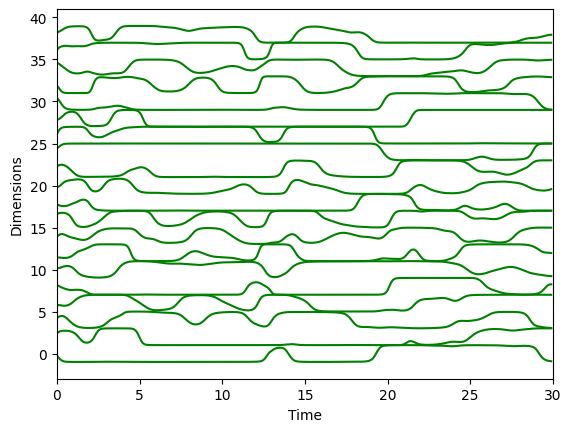

In [7]:
esn1 = EchoStateNet(num_input=1, num_hidden=500, num_output=20, dt=dt, g=1.8)
rs, ys = esn1.simulate(xs)
targets = rs[:, 0: esn1.num_output]  # This will be the training data for the trained ESN

fig, ax = plt.subplots()
ax.plot(times, targets + 2 * np.arange(0, esn1.num_output), 'g')
ax.set_xlim((0, T))
ax.set_ylabel("Dimensions")
ax.set_xlabel("Time");

Un-trained ESN.

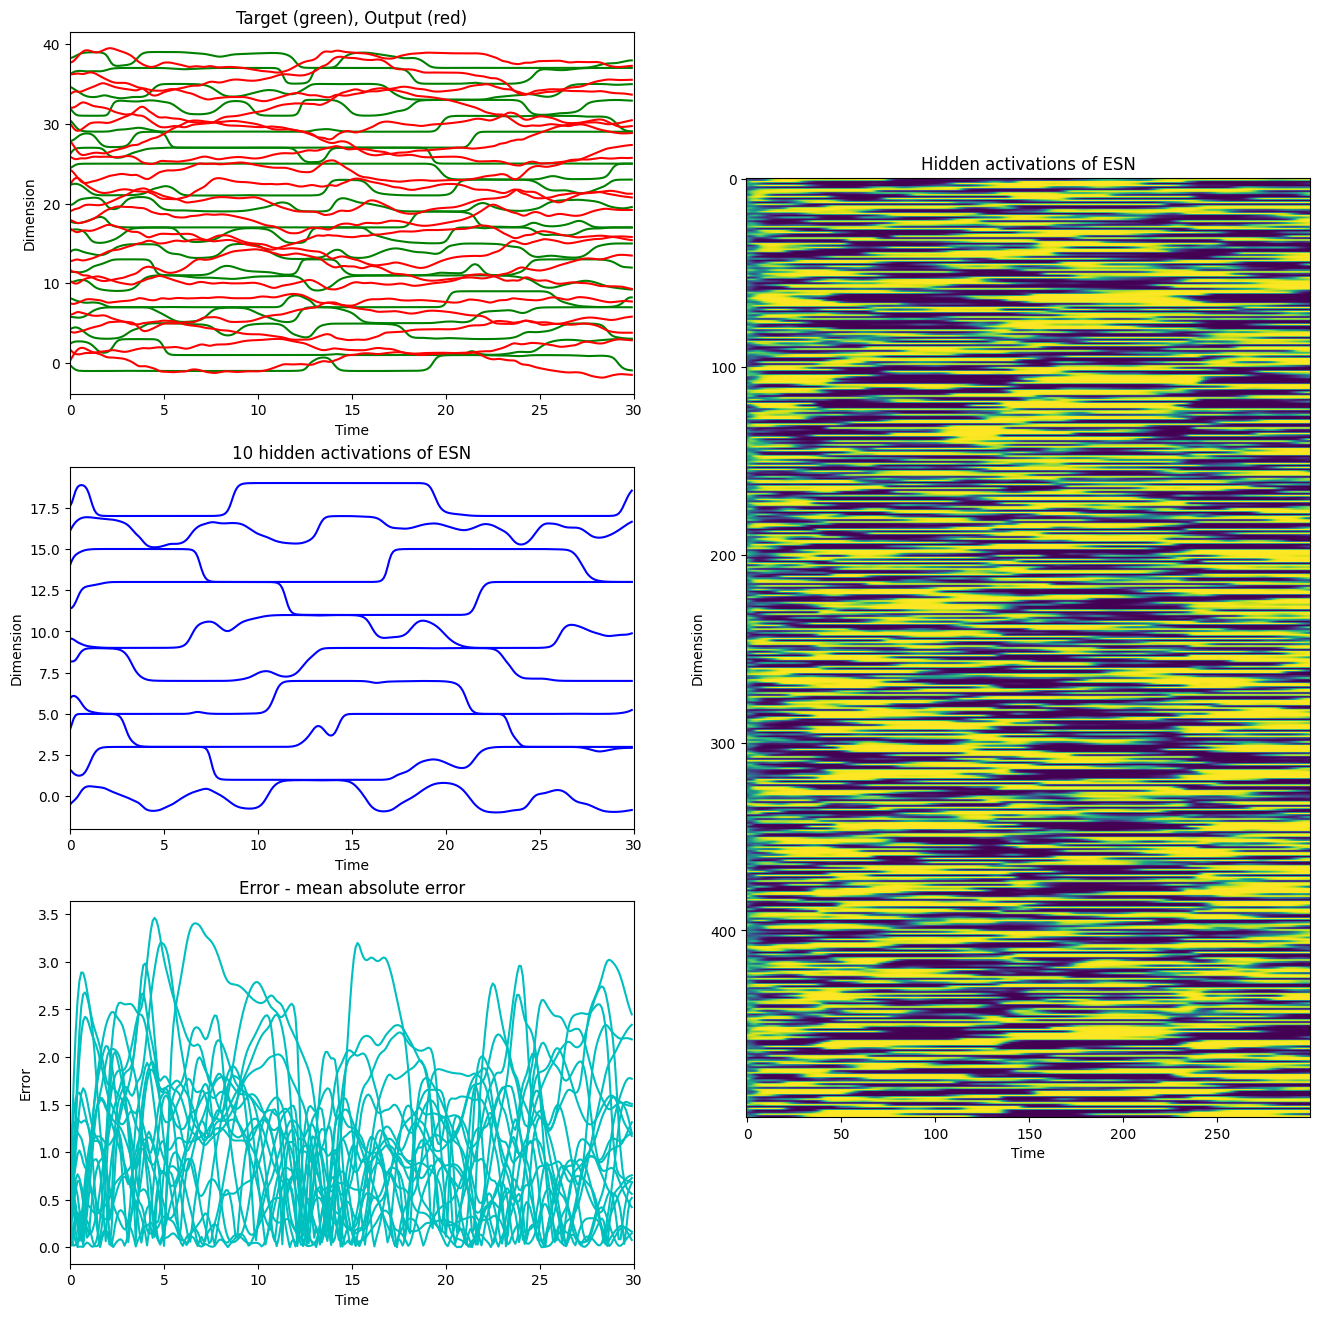

In [8]:
esn2 = EchoStateNet(num_input=1, num_hidden=500, num_output=20, dt=dt, g=1.5)
rs, ys = esn2.simulate(xs)  # the untrained ESN
print_force(times, rates=rs, outs=ys, targets=targets, duration=T, num_to_plot=10)

Trained ESN

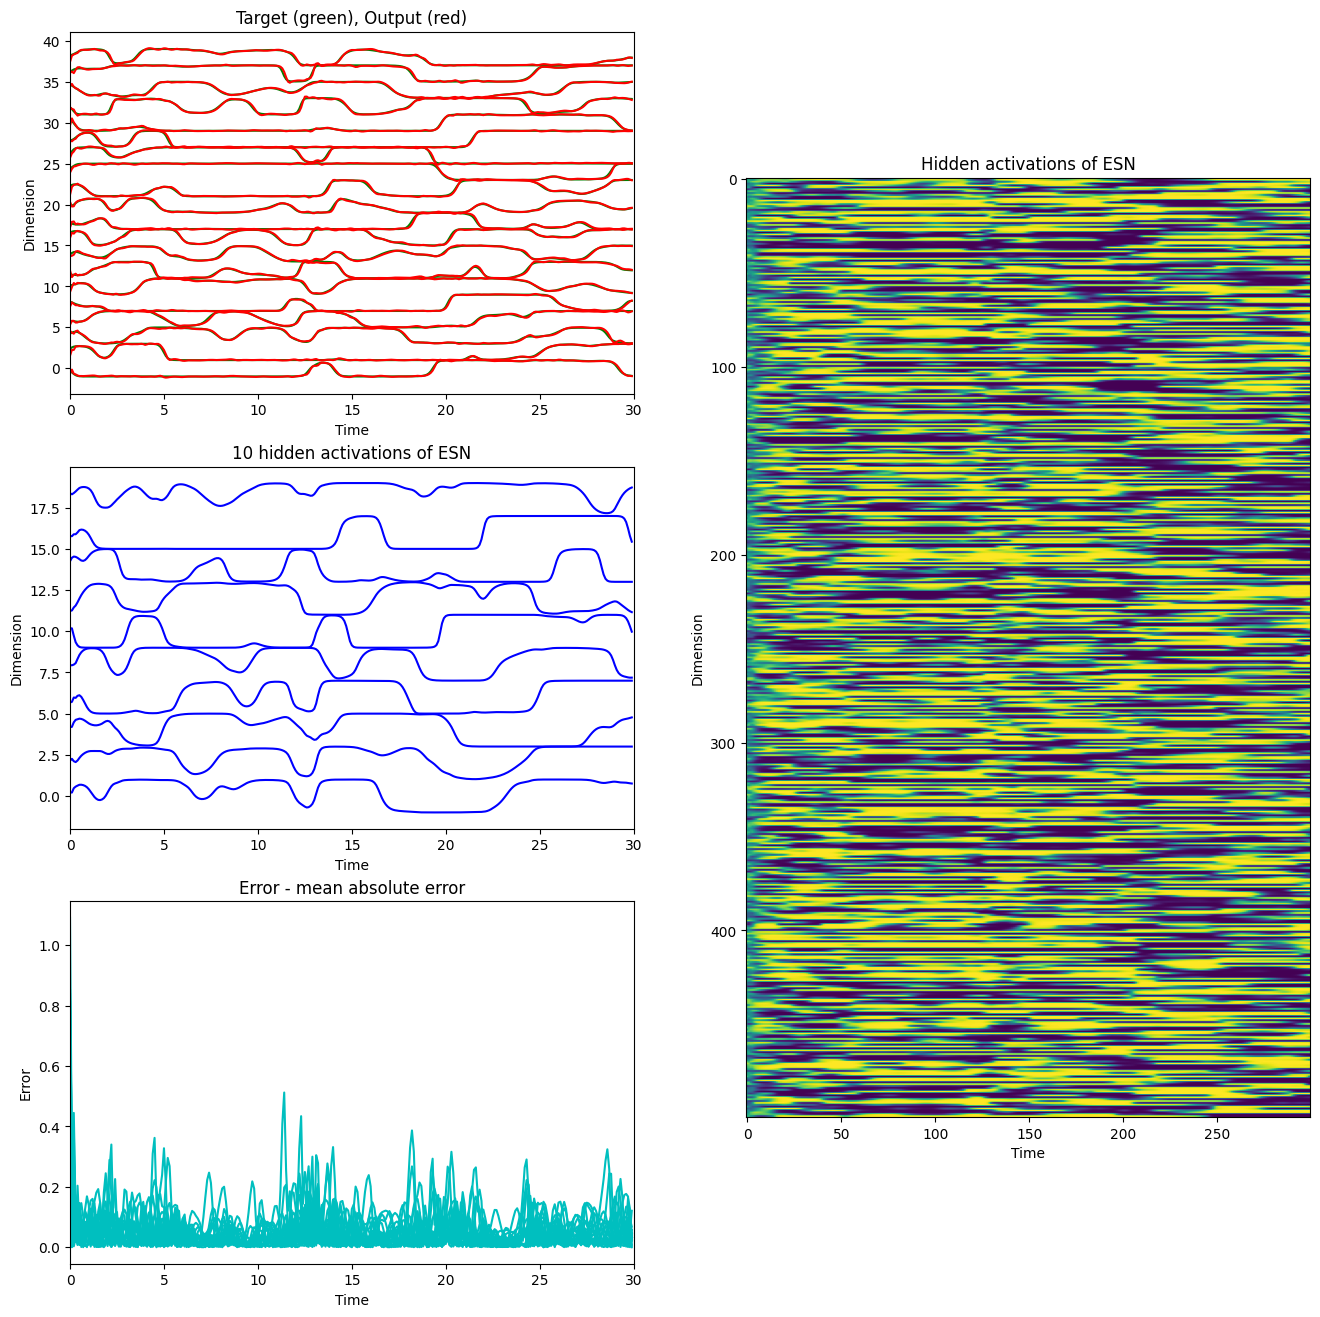

In [9]:
esn3 = EchoStateNet(num_input=1, num_hidden=500, num_output=20, dt=dt, g=1.5, alpha=1.)
rs, ys = esn3.train(xs=xs, targets=targets)  # train once
print_force(times, rates=rs, outs=ys, targets=targets, duration=T, num_to_plot=10)

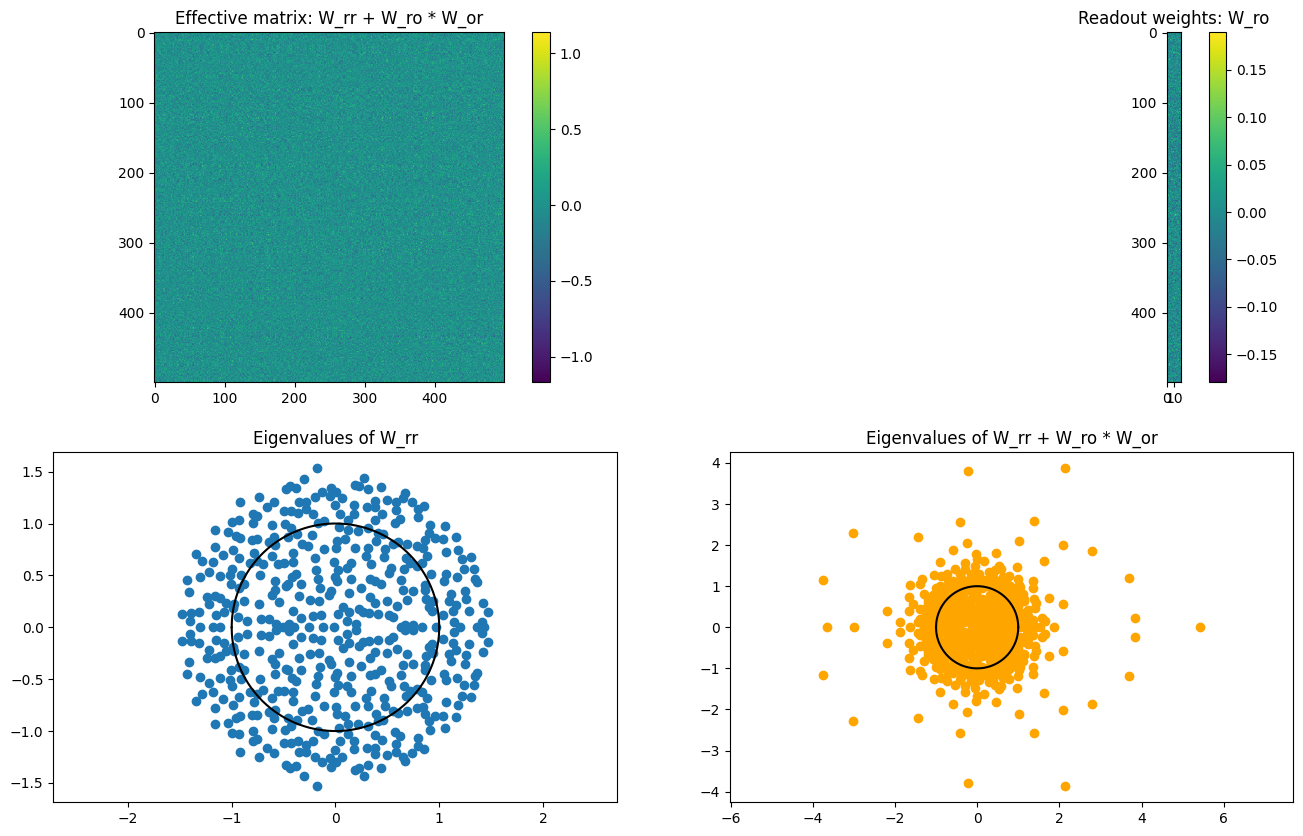

In [10]:
plot_params(esn3)